#Importing Libraries

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score

In [8]:
data = pd.read_csv('/content/ALL_FAIL_LOG_VIBE_0_Add_Random.csv')

# Preprocessing and EDA

In [9]:
print("Dataset Shape:", data.shape)
print("\nColumns:\n", data.columns)
print("\nSample Data:\n", data.head())
print("\nMissing Values:\n", data.isnull().sum())

Dataset Shape: (8638, 8)

Columns:
 Index(['LineNo', 'TimeUS', 'IMU', 'VibeX', 'VibeY', 'VibeZ', 'Clip', 'labels'], dtype='object')

Sample Data:
    LineNo     TimeUS  IMU     VibeX     VibeY     VibeZ  Clip  labels
0  424709  503763414    0  0.120009  0.108398  0.148239     0       4
1  426871  506163287    0  0.003210  0.003270  0.002992     0       4
2  435120  516463332    0  0.002998  0.003317  0.002864     0       4
3  145047  192963617    0  0.163687  0.116775  0.247265     0       0
4  430951  511263746    0  0.002952  0.002766  0.002777     0       4

Missing Values:
 LineNo    0
TimeUS    0
IMU       0
VibeX     0
VibeY     0
VibeZ     0
Clip      0
labels    0
dtype: int64


In [10]:
print("\nData Types:\n", data.dtypes)


Data Types:
 LineNo      int64
TimeUS      int64
IMU         int64
VibeX     float64
VibeY     float64
VibeZ     float64
Clip        int64
labels      int64
dtype: object



Label Distribution:
 labels
0    4059
4    1376
2    1237
1    1138
3     828
Name: count, dtype: int64


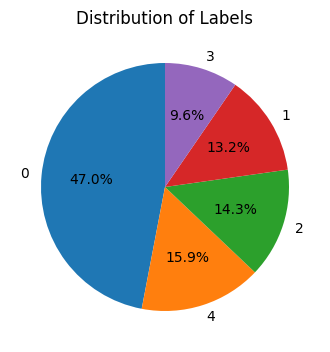

In [11]:
if 'labels' in data.columns:
    label_counts = data['labels'].value_counts()
    print("\nLabel Distribution:\n", label_counts)
    plt.figure(figsize=(4,5))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Labels')
    plt.show()

In [12]:
# Encoding Categorical Data
if 'labels' in data.columns:
    label_encoder = LabelEncoder()
    data['labels'] = label_encoder.fit_transform(data['labels'])
    print("\nLabel Encoding Complete. Classes:", label_encoder.classes_)


Label Encoding Complete. Classes: [0 1 2 3 4]


In [13]:
# Feature Selection
X = data.drop(columns=['labels']).values  # Features
y = data['labels'].values  # Target

In [14]:
# Scaling Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=len(np.unique(y)))

In [16]:
# Reshaping for TCN (samples, time_steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

#Model

In [17]:
# Define the TCN Block
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

In [18]:
# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

In [19]:
# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # TCN Layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model

In [20]:
# Input shape for TCN
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])
num_classes = y_encoded.shape[1]

In [21]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
label_accuracies = []

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_fold, X_val_fold = X_reshaped[train_index], X_reshaped[val_index]
    y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    model = build_tcn_attention_model(input_shape, num_classes)
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracy:.4f}")
    accuracies.append(accuracy)

    # Predictions
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_fold, axis=1)

    # Accuracy per label
    label_acc = []
    for label in range(num_classes):
        label_indices = (y_true_classes == label)
        label_acc.append(accuracy_score(y_true_classes[label_indices], y_pred_classes[label_indices]))
    label_accuracies.append(label_acc)

    fold_no += 1


Training fold 1...
Validation Accuracy for fold 1: 0.8189
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Training fold 2...
Validation Accuracy for fold 2: 0.6927
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Training fold 3...
Validation Accuracy for fold 3: 0.6458
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Training fold 4...
Validation Accuracy for fold 4: 0.5918
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Training fold 5...
Validation Accuracy for fold 5: 0.7556
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [22]:
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 1, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 1, 64)               │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_14 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_4 (AttentionLayer)   │ (None, 64)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,521 (365.32 KB)

 Trainable params: 31,045 (121.27 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 62,092 (242.55 KB)

In [23]:
# Calculate average accuracy
average_accuracy = np.mean(accuracies)
print(f"\nAverage Accuracy across all folds: {average_accuracy:.4f}")


Average Accuracy across all folds: 0.7010


In [24]:
# Average accuracy per label
label_accuracies = np.mean(label_accuracies, axis=0)
for idx, acc in enumerate(label_accuracies):
    print(f"Label {idx} Accuracy: {acc:.4f}")

Label 0 Accuracy: 0.9129
Label 1 Accuracy: 0.8425
Label 2 Accuracy: 0.4220
Label 3 Accuracy: 0.2789
Label 4 Accuracy: 0.4637


In [25]:
# Evaluate the last fold predictions
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_fold, axis=1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [26]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes,digits = 4))


Classification Report:

              precision    recall  f1-score   support

           0     0.6617    0.9802    0.7900       810
           1     0.9184    0.8696    0.8933       207
           2     1.0000    0.1587    0.2740       252
           3     1.0000    0.5196    0.6838       179
           4     1.0000    0.7097    0.8302       279

    accuracy                         0.7556      1727
   macro avg     0.9160    0.6476    0.6943      1727
weighted avg     0.8315    0.7556    0.7226      1727



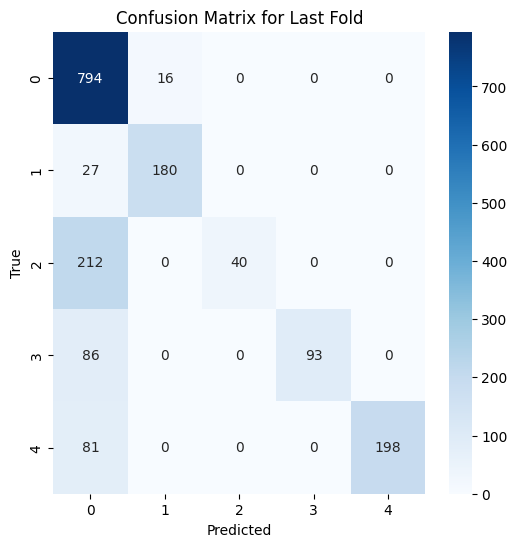

In [27]:
# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Last Fold')
plt.show()

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Distribution of predicted labels (entire dataset):
0    6000
4     990
1     980
3     465
2     200
Name: count, dtype: int64


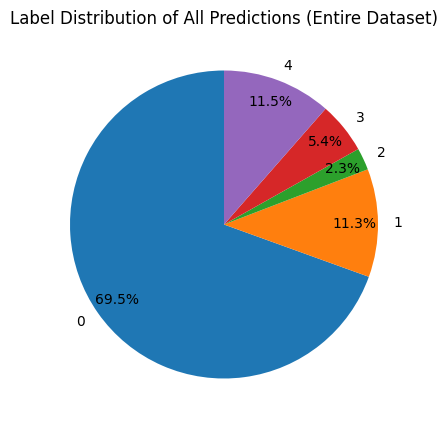

In [28]:
# Create lists to collect predictions
all_y_pred = []
all_y_true = []

for train_index, val_index in kf.split(X_reshaped):
    # ... (training code for each fold remains the same)

    # Predictions from this fold
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_fold, axis=1)

    # Append predictions and true labels for this fold
    all_y_pred.extend(y_pred_classes)
    all_y_true.extend(y_true_classes)

# After all folds are complete, you can now examine the distribution
all_y_pred = np.array(all_y_pred)
all_y_true = np.array(all_y_true)

# Distribution of predictions across all data
print("\nDistribution of predicted labels (entire dataset):")
print(pd.Series(all_y_pred).value_counts())

# Ensure label_encoder.classes_ contains all possible labels, including those with zero counts
unique_labels = np.unique(all_y_pred)

# Initialize a dictionary with zero counts for all labels
label_counts = {label: 0 for label in range(len(label_encoder.classes_))}

# Count the occurrences of each predicted label
for label in all_y_pred:
    label_counts[label] += 1

# Create a list of counts and corresponding label names
counts = [label_counts[label] for label in range(len(label_encoder.classes_))]
label_names = label_encoder.classes_

# Plotting the pie chart for all predictions
plt.figure(figsize=(6,5))
plt.pie(counts, labels=label_names, autopct='%1.1f%%', startangle=90, pctdistance=0.85, labeldistance=1.1)
plt.title('Label Distribution of All Predictions (Entire Dataset)')
plt.show()


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
0    1200
4     198
1     196
3      93
2      40
Name: count, dtype: int64


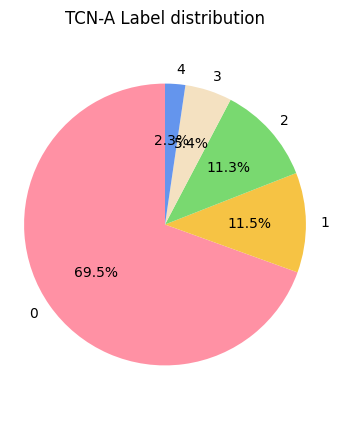

In [29]:
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)
class_counts = pd.Series(y_pred_classes).value_counts()
print(class_counts)
colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]

# Plot pie chart of predicted labels
plt.figure(figsize=(4, 5))
plt.pie(pd.Series(y_pred_classes).value_counts(), labels=label_encoder.classes_, autopct='%1.1f%%', startangle=90,colors=colors)
plt.axis('equal')
plt.title('TCN-A Label distribution')
plt.show()

In [31]:
#Misclassification
feature_names=['LineNo', 'TimeUS', 'IMU', 'VibeX', 'VibeY', 'VibeZ', 'Clip']

# Step 1: Get Model Predictions
y_pred_probs = model.predict(X_reshaped)  # Get probabilities
y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true_labels = np.argmax(y_encoded, axis=1)  # Convert true labels to class labels

# Step 2: Identify misclassified samples and their indices
mismatch_indices = np.where(y_true_labels != y_pred_labels)[0]  # Get actual indices

# Step 3: Create DataFrame of misclassified samples with indices
df_mismatches = pd.DataFrame(X_reshaped[mismatch_indices].reshape(-1, X_reshaped.shape[2]), columns=feature_names)
df_mismatches['Index'] = mismatch_indices  # Add original index
df_mismatches['Actual_Label'] = y_true_labels[mismatch_indices]
df_mismatches['Predicted_Label'] = y_pred_labels[mismatch_indices]

# Print misclassified samples with their original indices
print(df_mismatches[['Index', 'Actual_Label', 'Predicted_Label'] + feature_names])

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
      Index  Actual_Label  Predicted_Label    LineNo    TimeUS  IMU     VibeX  \
0         5             2                0  0.249012  0.160334  0.0 -0.330205   
1        14             4                0  1.608241  1.525855  0.0  0.055498   
2        18             1                0 -0.689537 -0.783257  0.0  0.100597   
3        30             2                0  0.030828 -0.059072  0.0 -0.330205   
4        42             2                0  0.109391  0.019945  0.0 -0.330205   
...     ...           ...              ...       ...       ...  ...       ...   
2175   8610             3                0  0.577813  0.717285  0.0 -0.030121   
2176   8617             2                0  0.027043  0.163402  0.0 -0.330205   
2177   8620             3                0  0.378959  0.517056  0.0 -0.015718   
2178   8627             3                0  0.512089  0.651311  0.0 -0.125674   
2179   8634             3                0  0.380487  0.518590  0.0 

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
0    1200
4     198
1     196
3      93
2      40
Name: count, dtype: int64


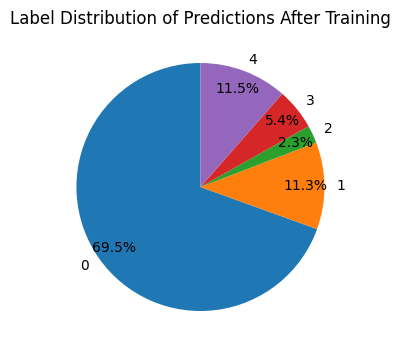

In [32]:
# Get the predicted labels after training (from the last fold or the final model)
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)

# Count the occurrences of each predicted label
class_counts = pd.Series(y_pred_classes).value_counts()
print(class_counts)
# Ensure label_encoder.classes_ contains all possible labels, including those with zero counts
unique_labels = np.unique(y_pred_classes)

# Initialize a dictionary with zero counts for all labels
label_counts = {label: 0 for label in range(len(label_encoder.classes_))}

# Count the occurrences of each predicted label
for label in y_pred_classes:
    label_counts[label] += 1

# Create a list of counts and corresponding label names
counts = [label_counts[label] for label in range(len(label_encoder.classes_))]
label_names = label_encoder.classes_

# Plotting the pie chart for all predictions
plt.figure(figsize=(4,5))
plt.pie(counts, labels=label_names, autopct='%1.1f%%', startangle=90, pctdistance=0.85, labeldistance=1.1)
plt.title('Label Distribution of Predictions After Training')
plt.show()


#XAI

In [33]:
import shap
from sklearn.cluster import KMeans

# Step 1: Flatten data for clustering (keeping shape (4319, 16))
X_flat = X_reshaped.reshape(X_reshaped.shape[0], -1)  # (4319, 16)

# Step 2: Apply KMeans clustering to select representative background data
num_clusters = 20  # Adjust based on dataset size
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_flat)

# Step 3: Select cluster centers as background data
background_data_kmeans = kmeans.cluster_centers_

# Step 4: Define SHAP KernelExplainer (Model-Agnostic)
def model_predict(X):
    X_input = X.reshape(X.shape[0], 1, X.shape[1])  # Reshape back to (N, 1, 16) for TCN
    return model.predict(X_input)

# Step 5: Create KernelExplainer
explainer_kernel = shap.KernelExplainer(model_predict, background_data_kmeans)

# Step 6: Compute SHAP values on a test subset
X_test_sample = X_flat[:200]  # Selecting a subset for SHAP analysis
shap_values_kernel = explainer_kernel.shap_values(X_test_sample,silent=True)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━

In [34]:
X_flat.shape

(8638, 7)

In [35]:
shap_values_kernel.shape

(200, 7, 5)

In [36]:
data_point_index = 0  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the first data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")


SHAP values for the first data point:
Feature 0: [0.04573846959093947, -0.022715204589115325, -0.0008368114628263881, 0.03441651847483008, -0.05660296410025556]
Feature 1: [-0.5096296903223686, -0.02403038161792067, -0.006233282399402951, -0.0748157180133305, 0.6147090798754846]
Feature 2: [0.0, 0.0, 0.0, 0.0, 0.0]
Feature 3: [0.0735340485837042, -0.00016531659067345328, -0.004663492294379637, -0.2106894969777704, 0.14198426964293592]
Feature 4: [0.16276839425098485, 0.0009130817551816288, -0.005682814773335911, -0.31593066696000693, 0.15793201526593115]
Feature 5: [-0.09242549835172181, -0.0011931987135196168, -0.005062494344368927, 0.01323563689517282, 0.08544556388617792]
Feature 6: [0.0, 0.0, 0.0, 0.0, 0.0]


In [37]:
data_point_index = 100  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the first data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")


SHAP values for the first data point:
Feature 0: [-0.008383923760538536, -0.020132531853217922, -0.005406552481914672, -0.02111165062034831, 0.0550346249646542]
Feature 1: [0.2616945729133223, -0.018240687271949513, -0.003332880495402292, -0.03129838818219125, -0.2088226413813414]
Feature 2: [0.0, 0.0, 0.0, 0.0, 0.0]
Feature 3: [0.14051907667495636, 0.005478529221722532, 0.014504789292289818, -0.20272510303784222, 0.04222268426158753]
Feature 4: [0.2806222424347015, 0.010814937068262661, 0.017172933169389858, -0.3429861991655883, 0.03437605955260157]
Feature 5: [-0.06787719278369798, -0.0172883091146352, 0.01498457528146681, 0.04435486118694576, 0.02582603908543938]
Feature 6: [0.0, 0.0, 0.0, 0.0, 0.0]


In [38]:
data_point_index = 199  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the first data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")


SHAP values for the first data point:
Feature 0: [-0.40392663499161097, 0.2835288234042385, -0.004812610365577172, -0.04447967037004561, 0.1696900964168081]
Feature 1: [0.14728141193036728, 0.22862339422356703, -0.004232744311326361, -0.06652323200482668, -0.30514882283655187]
Feature 2: [0.0, 0.0, 0.0, 0.0, 0.0]
Feature 3: [0.11314647283119095, 0.041809603696518094, -0.004280209565633683, -0.18100132410924952, 0.030325454924164833]
Feature 4: [0.1762217473429608, 0.09359948996348327, -0.004609016624057363, -0.302814397445427, 0.0376021808566066]
Feature 5: [-0.12052005603148039, 0.06781608315245846, -0.004536766105760725, 0.04106585257128037, 0.016174897661691452]
Feature 6: [0.0, 0.0, 0.0, 0.0, 0.0]


In [39]:
# Compute mean absolute SHAP values per feature for each class
shap_importance_per_class = np.mean(np.abs(shap_values_kernel), axis=0)  # Shape: (16, 5)

# Convert to DataFrame for better readability
shap_df = pd.DataFrame(shap_importance_per_class, columns=['Normal', 'GPS Anomaly', 'Accelerometer Anomaly', 'Engine Anomaly', 'RC Anomaly'], index=feature_names)

# Display top contributing features for each anomaly type
for anomaly_class in shap_df.columns[1:]:  # Skip 'Normal'
    print(f"\nTop Contributing Features for {anomaly_class}:")
    print(shap_df[anomaly_class].sort_values(ascending=False))


Top Contributing Features for GPS Anomaly:
LineNo    0.062171
TimeUS    0.053477
VibeY     0.019218
VibeZ     0.014732
VibeX     0.012279
IMU       0.000000
Clip      0.000000
Name: GPS Anomaly, dtype: float64

Top Contributing Features for Accelerometer Anomaly:
TimeUS    0.008997
VibeY     0.007626
VibeZ     0.007049
VibeX     0.006846
LineNo    0.005523
IMU       0.000000
Clip      0.000000
Name: Accelerometer Anomaly, dtype: float64

Top Contributing Features for Engine Anomaly:
VibeY     0.309804
VibeX     0.193087
TimeUS    0.053302
VibeZ     0.040270
LineNo    0.032077
IMU       0.000000
Clip      0.000000
Name: Engine Anomaly, dtype: float64

Top Contributing Features for RC Anomaly:
TimeUS    0.263297
LineNo    0.144524
VibeY     0.049790
VibeX     0.045453
VibeZ     0.023691
IMU       0.000000
Clip      0.000000
Name: RC Anomaly, dtype: float64


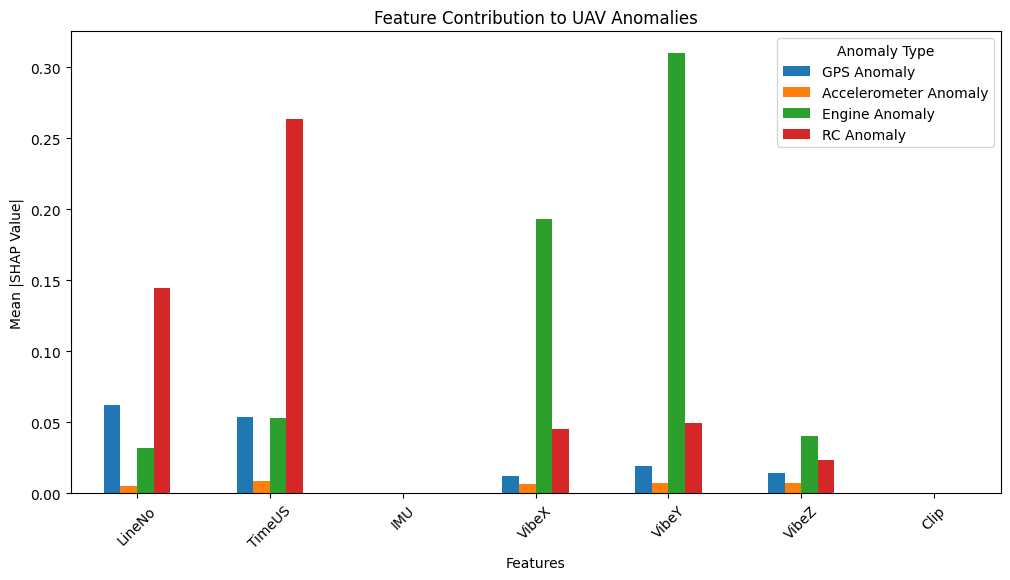

In [40]:
# Plot feature importance for each anomaly type
shap_df.iloc[:, 1:].plot(kind='bar', figsize=(12, 6), title="Feature Contribution to UAV Anomalies")
plt.xlabel("Features")
plt.ylabel("Mean |SHAP Value|")
plt.legend(title="Anomaly Type")
plt.xticks(rotation=45)
plt.show()